In [16]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score

In [3]:
#General aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
data = pd.read_csv("/content/support2.csv")

In [5]:
print(data.describe())

               age        death     hospdead         slos       d.time  \
count  9105.000000  9105.000000  9105.000000  9105.000000  9105.000000   
mean     62.650823     0.681054     0.259198    17.863042   478.449863   
std      15.593710     0.466094     0.438219    22.006440   560.383272   
min      18.041990     0.000000     0.000000     3.000000     3.000000   
25%      52.797000     0.000000     0.000000     6.000000    26.000000   
50%      64.856990     1.000000     0.000000    11.000000   233.000000   
75%      73.998960     1.000000     1.000000    20.000000   761.000000   
max     101.847960     1.000000     1.000000   343.000000  2029.000000   

            num.co          edu        scoma       charges         totcst  \
count  9105.000000  7471.000000  9104.000000  8.933000e+03    8217.000000   
mean      1.868644    11.747691    12.058546  5.999579e+04   30825.867768   
std       1.344409     3.447743    24.636694  1.026488e+05   45780.820986   
min       0.000000     0.

In [26]:
data.head()

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,1,0,5,2029,6,2,0,11.0,...,1.199951,141.0,7.459961,135.0,23.0,1968.0,7.0,7.0,5,7.0
2,60.33899,1,0,1,4,4,3,1,2,12.0,...,5.500000,132.0,7.250000,135.0,23.0,1968.0,0.0,1.0,0,1.0
3,52.74698,1,0,0,17,47,3,1,2,12.0,...,2.000000,134.0,7.459961,135.0,23.0,1968.0,1.0,0.0,0,0.0
4,42.38498,1,0,0,3,133,6,2,2,11.0,...,0.799927,139.0,7.419922,135.0,23.0,1968.0,0.0,0.0,4,0.0
5,79.88495,0,0,0,16,2029,0,0,1,12.0,...,0.799927,143.0,7.509766,135.0,23.0,1968.0,0.0,2.0,4,2.0


In [6]:
#Look for missings
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

edu        1634
income     2982
scoma         1
charges     172
totcst      888
totmcst    3475
avtisst      82
race         42
sps           1
aps           1
surv2m        1
surv6m        1
prg2m      1649
prg6m      1633
dnr          30
dnrday       30
meanbp        1
wblc        212
hrt           1
resp          1
temp          1
pafi       2325
alb        3372
bili       2601
crea         67
sod           1
ph         2284
glucose    4500
bun        4352
urine      4862
adlp       5641
adls       2867
sfdm2      1400
dtype: int64


In [7]:
#Filling missings
for column in data.select_dtypes(include=[np.number]).columns:
    data[column].fillna(data[column].median(), inplace=True)

#Encoding Categoricals
label_encoders = {}
for column in data.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

<ipython-input-8-b7105d4b2f96>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='death', data=data, palette='pastel')


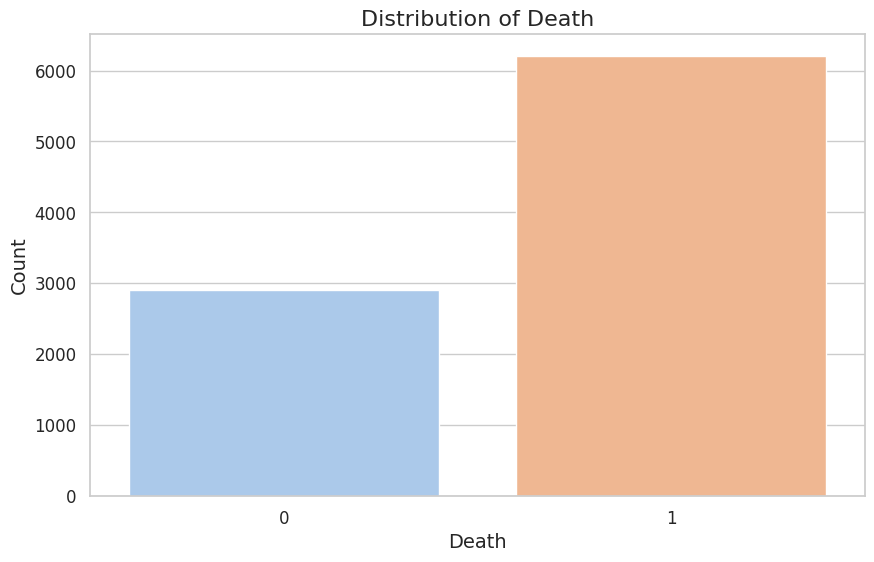

In [8]:
#Distribution of target variable (Death)
plt.figure(figsize=(10, 6))
sns.countplot(x='death', data=data, palette='pastel')
plt.title('Distribution of Death', fontsize=16)
plt.xlabel('Death', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

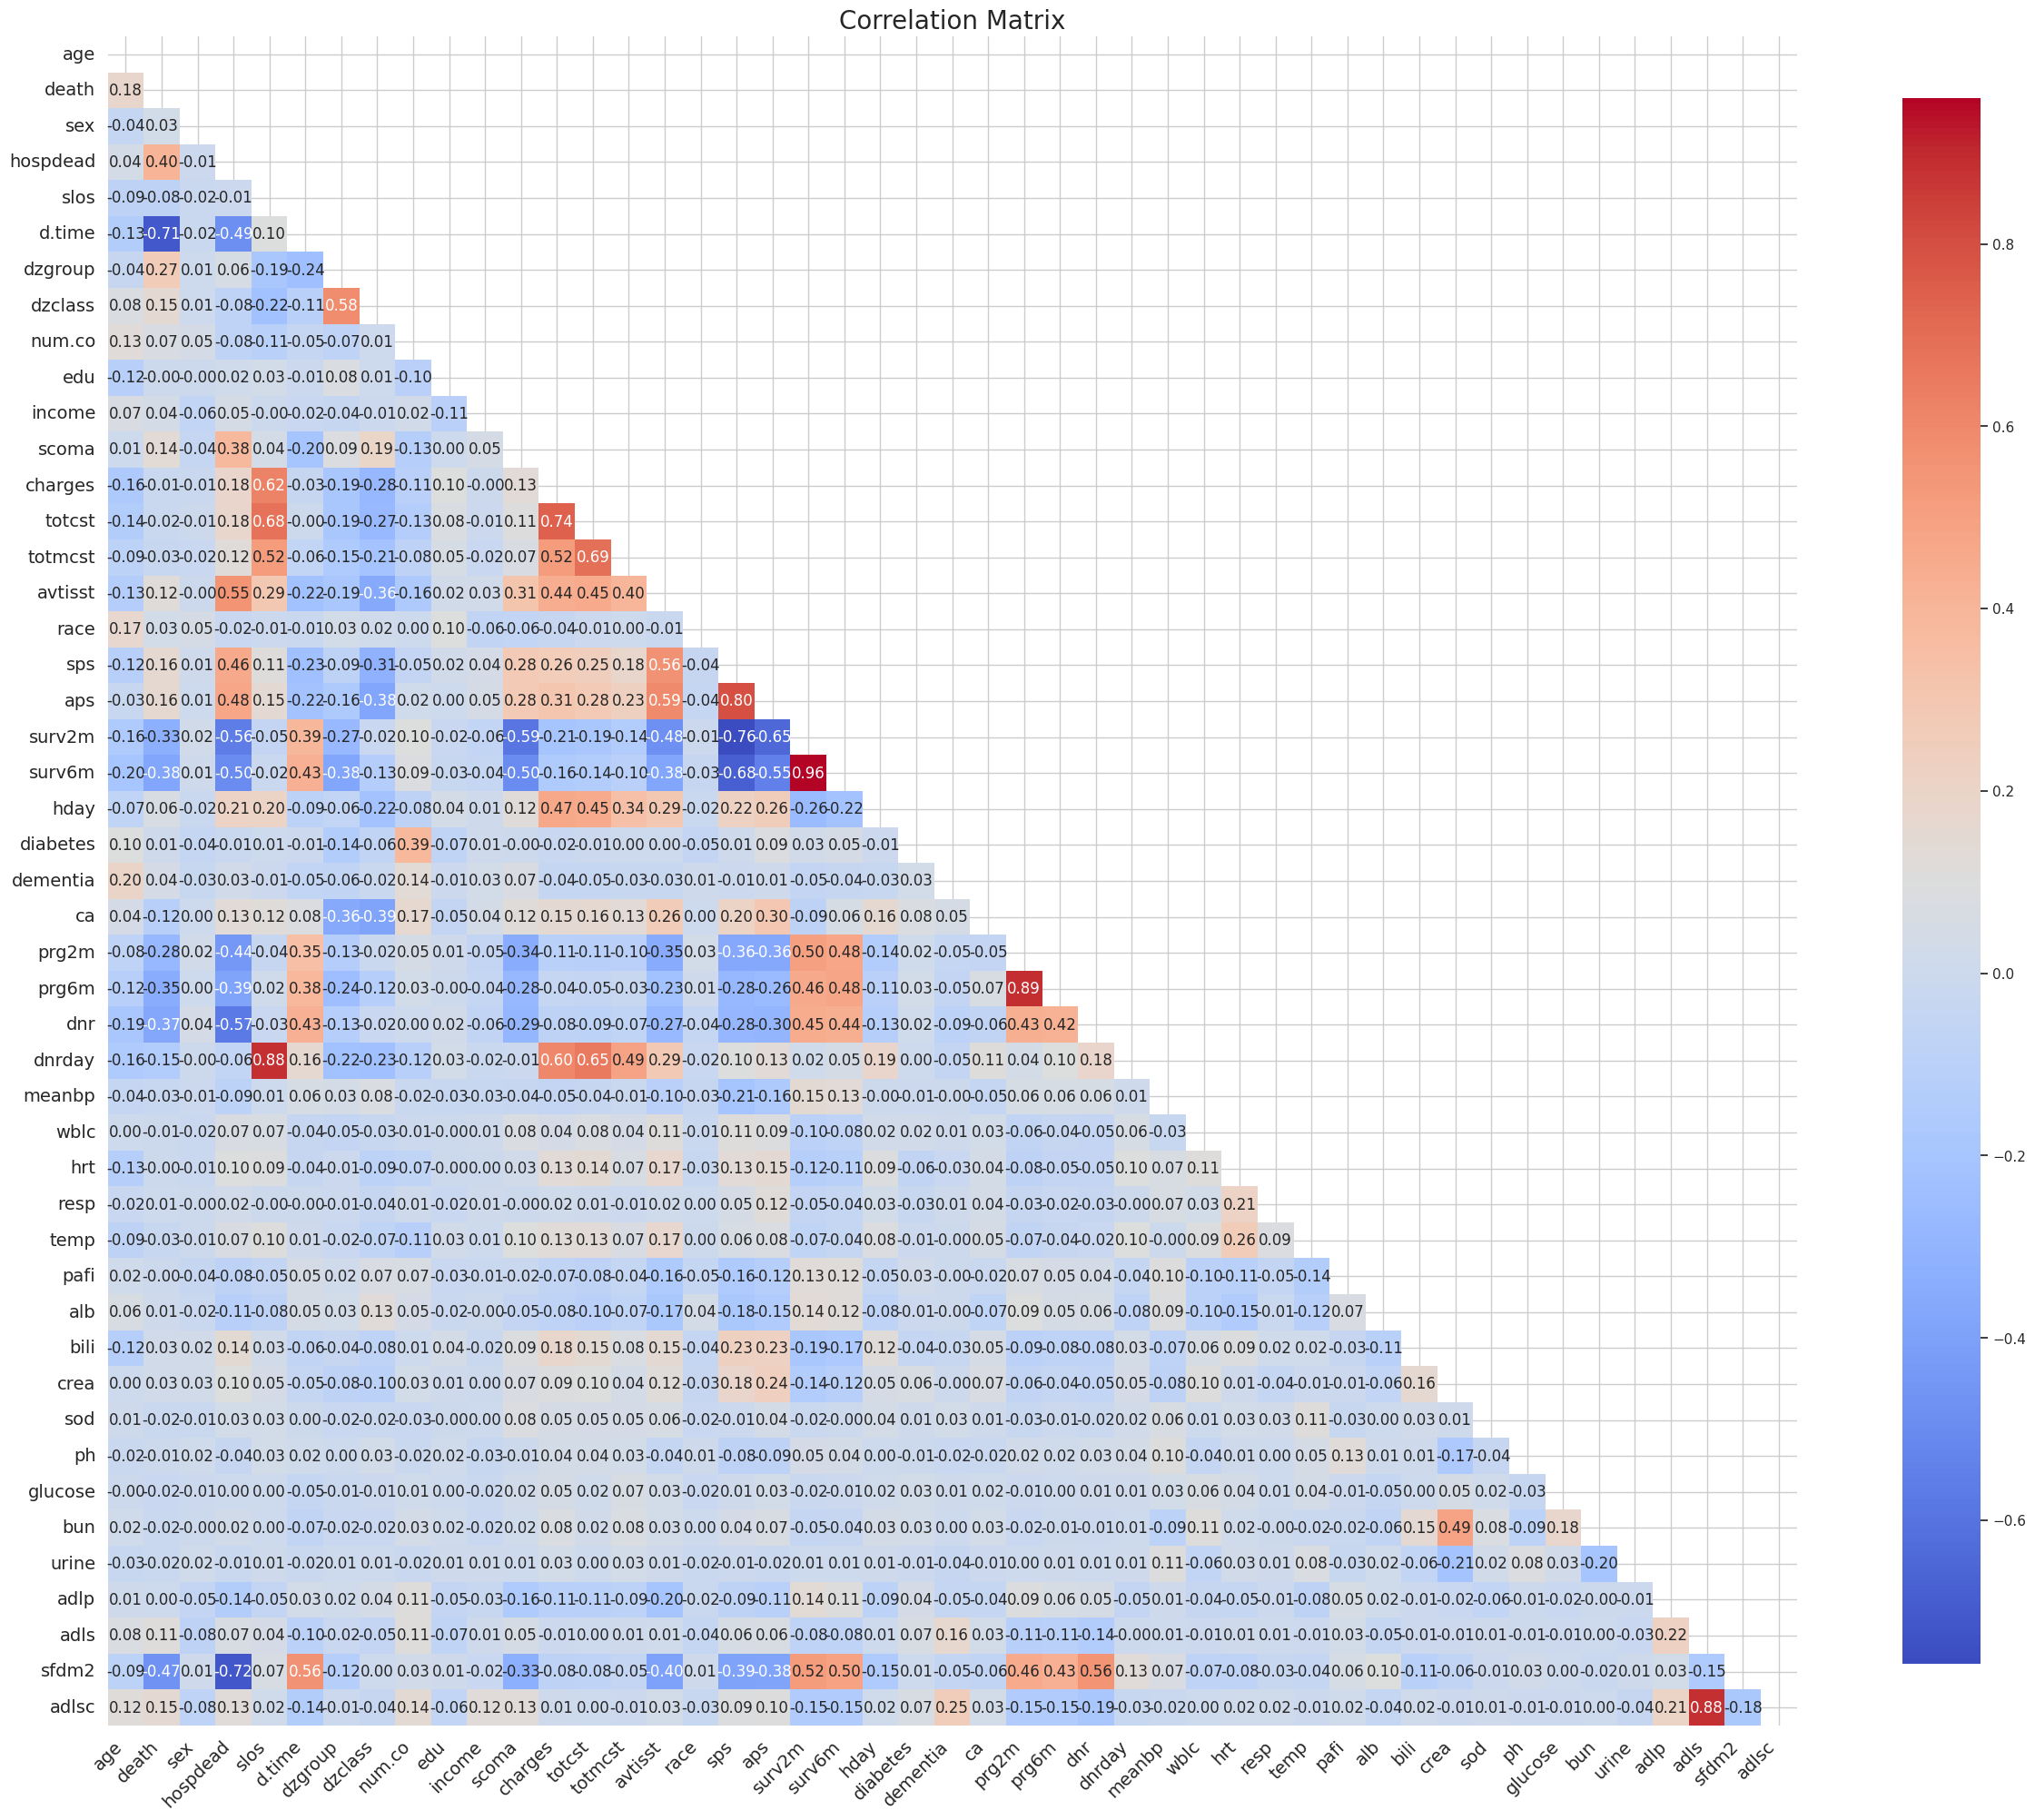

In [9]:
#Generate a correlation heatmap that includes the remapped features
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(30, 28))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 12}, cbar_kws={'shrink': .8}, mask=mask, square=True)
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.show()

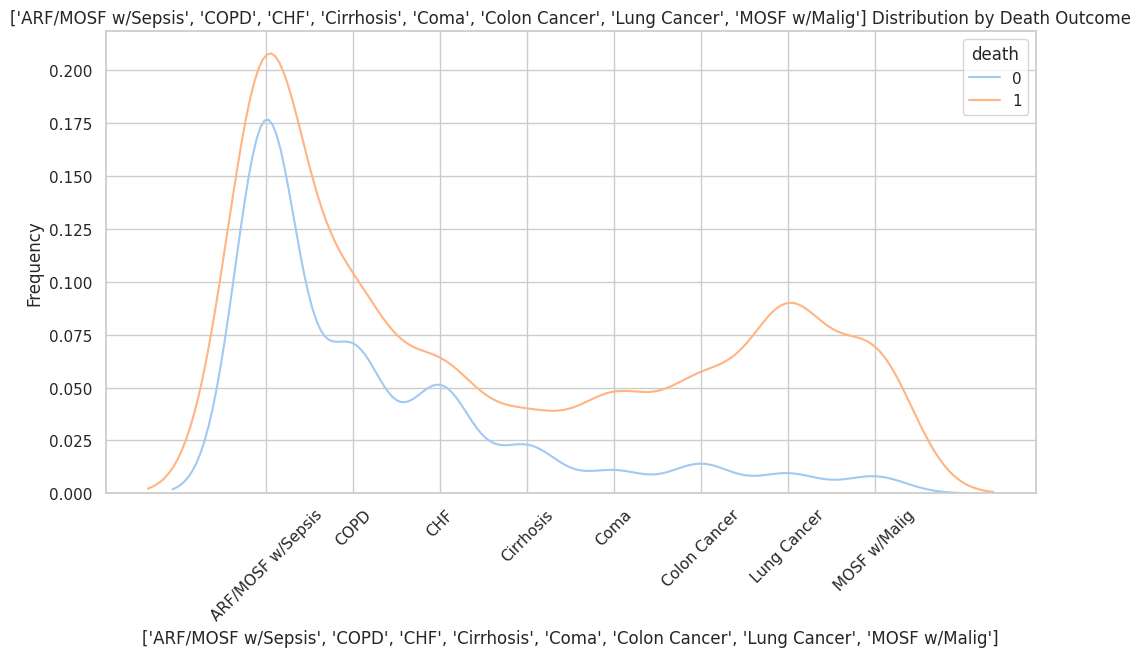

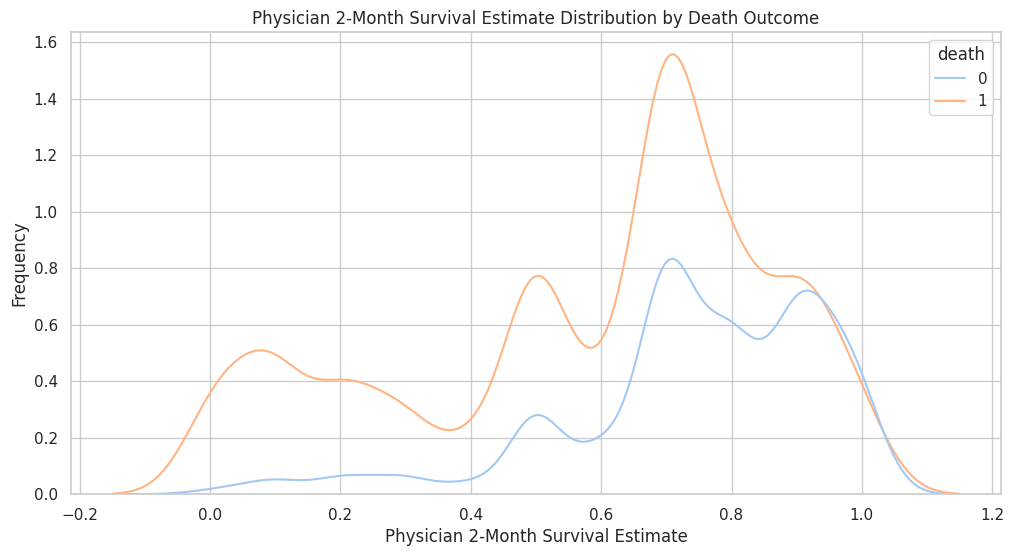

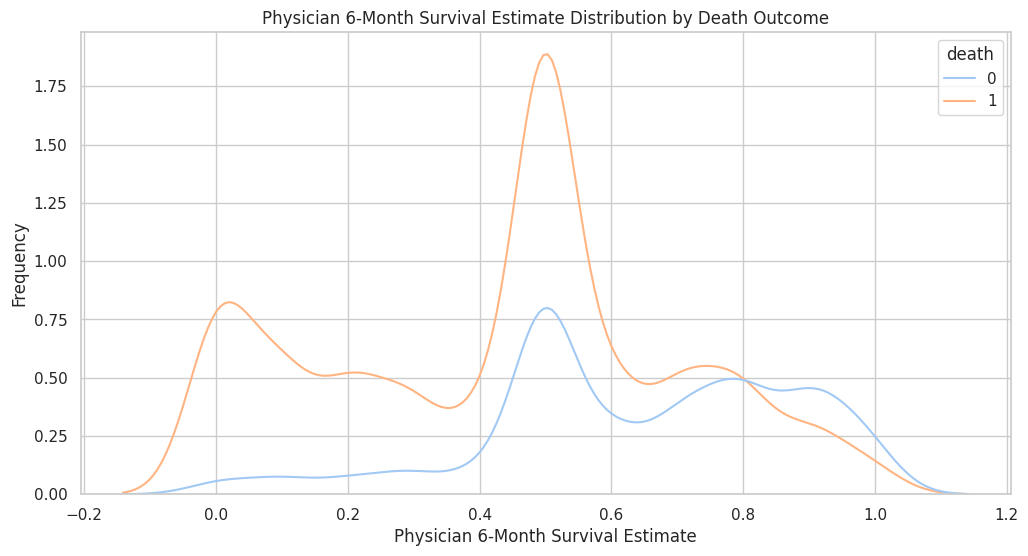

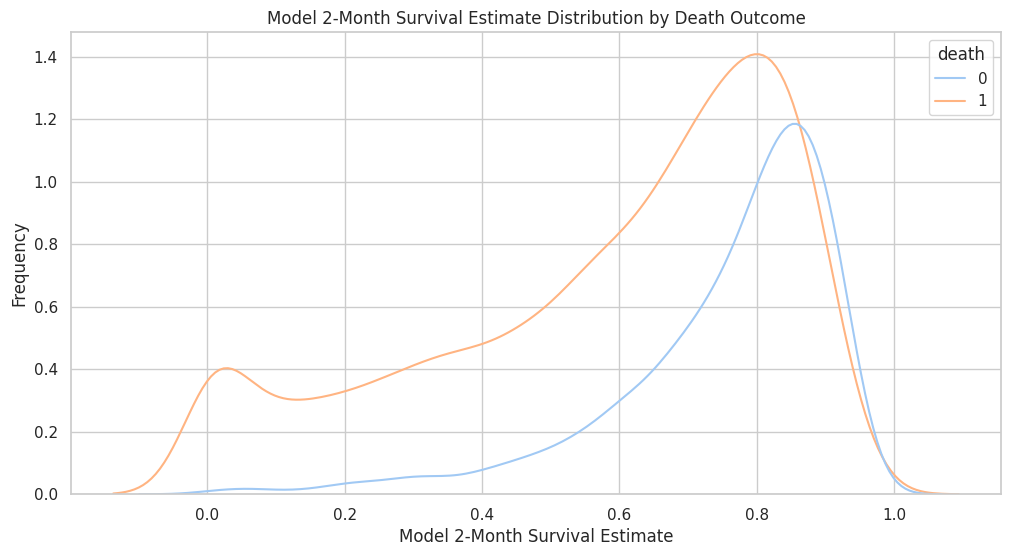

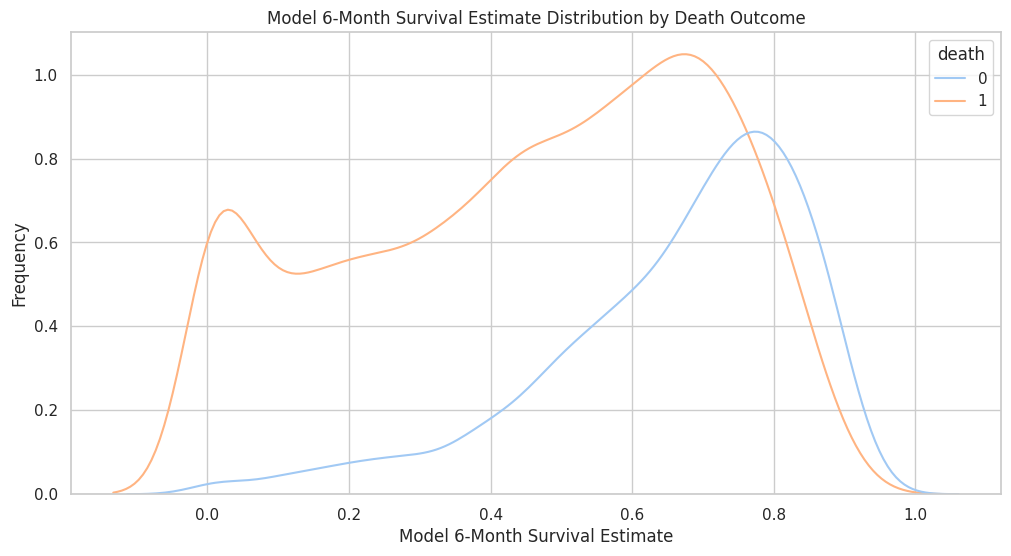

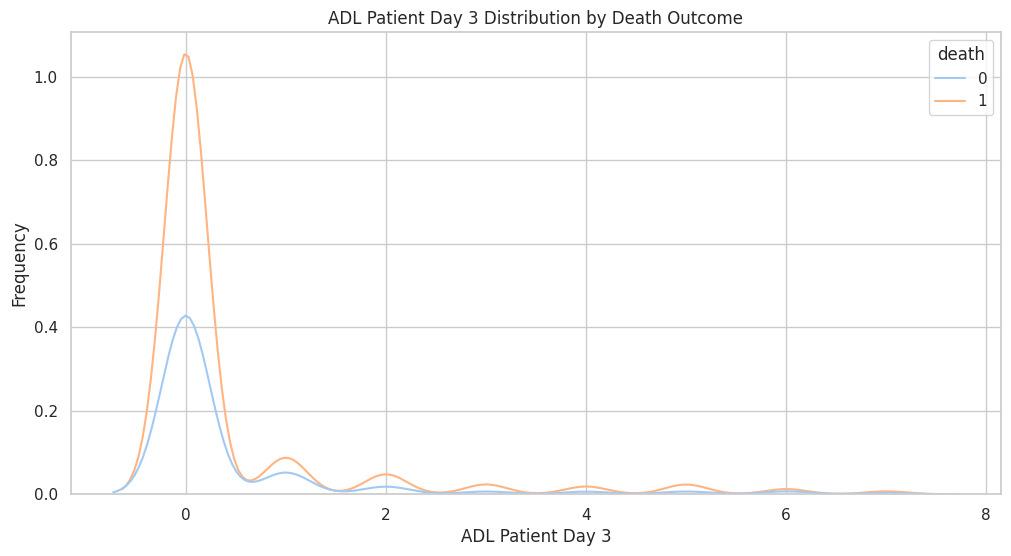

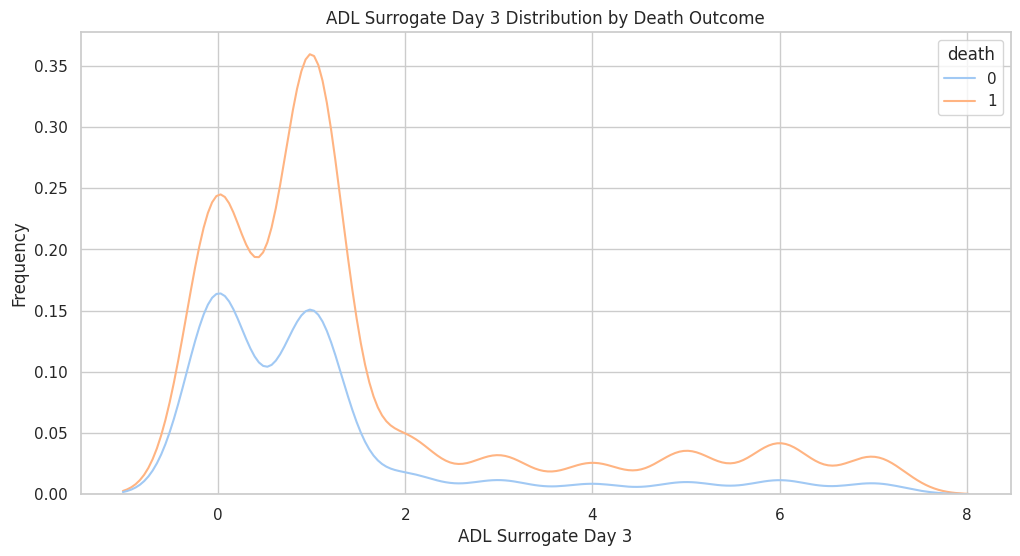

In [10]:
#Overlaying histograms, with labels
variables = ['dzgroup', 'prg2m', 'prg6m', 'surv2m', 'surv6m', 'adlp', 'adls']
labels = {
    'dzgroup': ['ARF/MOSF w/Sepsis', 'COPD', 'CHF', 'Cirrhosis', 'Coma', 'Colon Cancer', 'Lung Cancer', 'MOSF w/Malig'],
    'prg2m': 'Physician 2-Month Survival Estimate',
    'prg6m': 'Physician 6-Month Survival Estimate',
    'surv2m': 'Model 2-Month Survival Estimate',
    'surv6m': 'Model 6-Month Survival Estimate',
    'adlp': 'ADL Patient Day 3',
    'adls': 'ADL Surrogate Day 3'
}

for var in variables:
    sns.kdeplot(data=data, x=var, hue='death', palette='pastel')
    plt.title(f'{labels.get(var, var)} Distribution by Death Outcome')
    plt.xlabel(labels.get(var, var))
    plt.ylabel('Frequency')
    if var == 'dzgroup':
        plt.xticks(ticks=range(len(labels[var])), labels=labels[var], rotation=45)
    plt.show()

In [11]:
#Define Features
X = data.drop(columns=['death'])
y = data['death']

In [12]:
#Train/Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#Standardizing Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, to optimize and train each model:

In [13]:
#Logistic Regression:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize and train model
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_log_reg = grid_search.best_estimator_
print(f"Best Logistic Regression Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_log_reg.predict(X_test)
y_pred_prob = best_log_reg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"Logistic Regression - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.8660076880834706, Recall: 0.9103504482477588, AUC: 0.9451414443264483, Precision: 0.8928856914468425


In [14]:
#Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and train model
dec_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(dec_tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_dec_tree = grid_search.best_estimator_
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_dec_tree.predict(X_test)
y_pred_prob = best_dec_tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"Decision Tree - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree - Accuracy: 0.929159802306425, Recall: 0.9225753871230644, AUC: 0.9427911277952028, Precision: 0.9708404802744426


In [15]:
#Randon Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and train model
rand_forest = RandomForestClassifier()
grid_search = GridSearchCV(rand_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_rand_forest = grid_search.best_estimator_
print(f"Best Random Forest Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_rand_forest.predict(X_test)
y_pred_prob = best_rand_forest.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"Random Forest - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - Accuracy: 0.9231191652937946, Recall: 0.9095354523227384, AUC: 0.9735592820352397, Precision: 0.9746724890829694


In [17]:
#XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize and train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_xgb = grid_search.best_estimator_
print(f"Best XGBoost Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_xgb.predict(X_test)
y_pred_prob = best_xgb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"XGBoost - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
XGBoost - Accuracy: 0.941790225151016, Recall: 0.9225753871230644, AUC: 0.9802480112178562, Precision: 0.9903762029746281


In [25]:
#LightGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100, 150],  # Expanded range for num_leaves
    'max_depth': [3, 5, 7, 10]  # Expanded range for max_depth
}

# Initialize and train model
lgbm = LGBMClassifier()
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_lgbm = grid_search.best_estimator_
print(f"Best LightGBM Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_lgbm.predict(X_test)
y_pred_prob = best_lgbm.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"LightGBM - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4974, number of negative: 2310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5252
[LightGBM] [Info] Number of data points in the train set: 7284, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.682867 -> initscore=0.766977
[LightGBM] [Info] Start training from score 0.766977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [18]:
#Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize and train model
grad_boost = GradientBoostingClassifier()
grid_search = GridSearchCV(grad_boost, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_grad_boost = grid_search.best_estimator_
print(f"Best Gradient Boosting Parameters: {grid_search.best_params_}")

# Predictions and evaluation
y_pred = best_grad_boost.predict(X_test)
y_pred_prob = best_grad_boost.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)

print(f"Gradient Boosting - Accuracy: {accuracy}, Recall: {recall}, AUC: {auc}, Precision: {precision}")

Best Gradient Boosting Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Gradient Boosting - Accuracy: 0.9450851180669961, Recall: 0.9274653626731867, AUC: 0.9792381846171578, Precision: 0.9904264577893821



Visualizing the LightGBM Model:


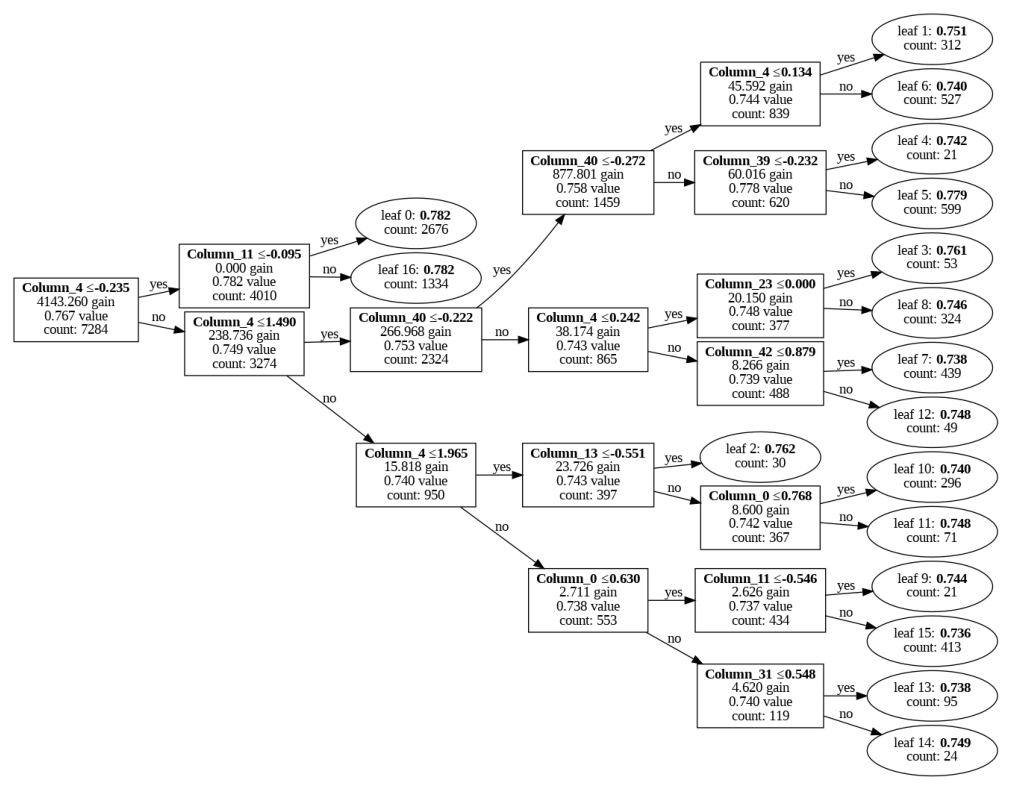

In [27]:
#Visualize the tree plot of LightGBM: Identified as the most reliable predictive model tested overall
print("\nVisualizing the LightGBM Model:")
ax = lgb.plot_tree(best_lgbm, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()


Visualizing feature importance in the LightGBM Model:


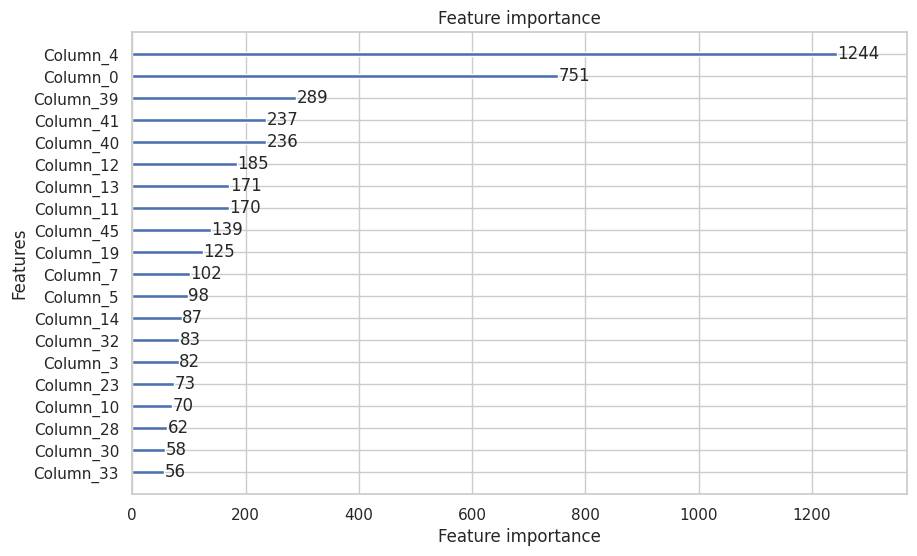

In [28]:
#Visualize feature importance of the LightGBM model: Identified as the most reliable predictive model tested overall
print("\nVisualizing feature importance in the LightGBM Model:")
ax = lgb.plot_importance(best_lgbm, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.show()